# SDSS QUERY

# Import

In [1]:
import os
import numpy as np #python numeric package
import pandas as pd #to handle data set organized as catalogue, e.g. csv
import matplotlib.pyplot as plt #for plots
import seaborn as sns #statistical data visualization based on matplotlib
from astropy.io import fits #to handle fits file
from sklearn.model_selection import train_test_split, GridSearchCV #functions used to: handle the train/test split, perform a grid search 
from sklearn.ensemble import RandomForestRegressor #Regressor based on RF
from sklearn.neighbors import KNeighborsRegressor #Regressor based on kNN
from sklearn.neural_network import MLPRegressor #Regressor based on MLP
from sklearn.preprocessing import StandardScaler, MinMaxScaler #dataset scalers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #functions to compute metrics
import requests #to download data
import time #to measure the time ranges


C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# funzioni per visualizzazione

In [2]:
# Function for scatter plot and metric printing
# metrics are computed by using the normalized delta z, as usual in redshift context
# Delta_z_norm= (z_spec-z_phot)/(1+z_spec)
# outliers are defined as |delta_z_norm| > 0.15, as ususal in this kind of papers
def scatter_plot(y_true, y_pred, title):
    residuals = (y_pred - y_true) / (1 + y_true)
    mean_res = np.mean(residuals)
    std_res = np.std(residuals, ddof=1)
    outlier_threshold = 0.15
    outlier_mask = np.abs(residuals) > outlier_threshold
    outlier_percentage = np.mean(outlier_mask) * 100
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.8, s=0.1)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')  # Diagonale
    plt.plot([min(y_true), max(y_true)], [min(y_true) * (1 + outlier_threshold), max(y_true) * (1 + outlier_threshold)], linestyle='--', color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true) * (1 - outlier_threshold), max(y_true) * (1 - outlier_threshold)], linestyle='--', color='blue')
    plt.xlabel("z true")
    plt.ylabel("z pred")
    plt.title(title)
    plt.ylim(0, 6)
    plt.xlim(0,6)
    plt.show()
    print(f"{title} - Mean Residual: {mean_res}, Std Residual: {std_res}, Outliers > {outlier_threshold}: {outlier_percentage:.2f}%")

    
# Function for visualizing feature distribution
def plot_feature_distributions(df, features, cols=5):
    rows = int(np.ceil(len(features) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        plot1=sns.histplot(df[feature], ax=axes[i], bins=30, kde=False,element="step")
        plot1.set_yscale("log")
        axes[i].set_title(feature)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()    

# Download data, read file, train/test splitting

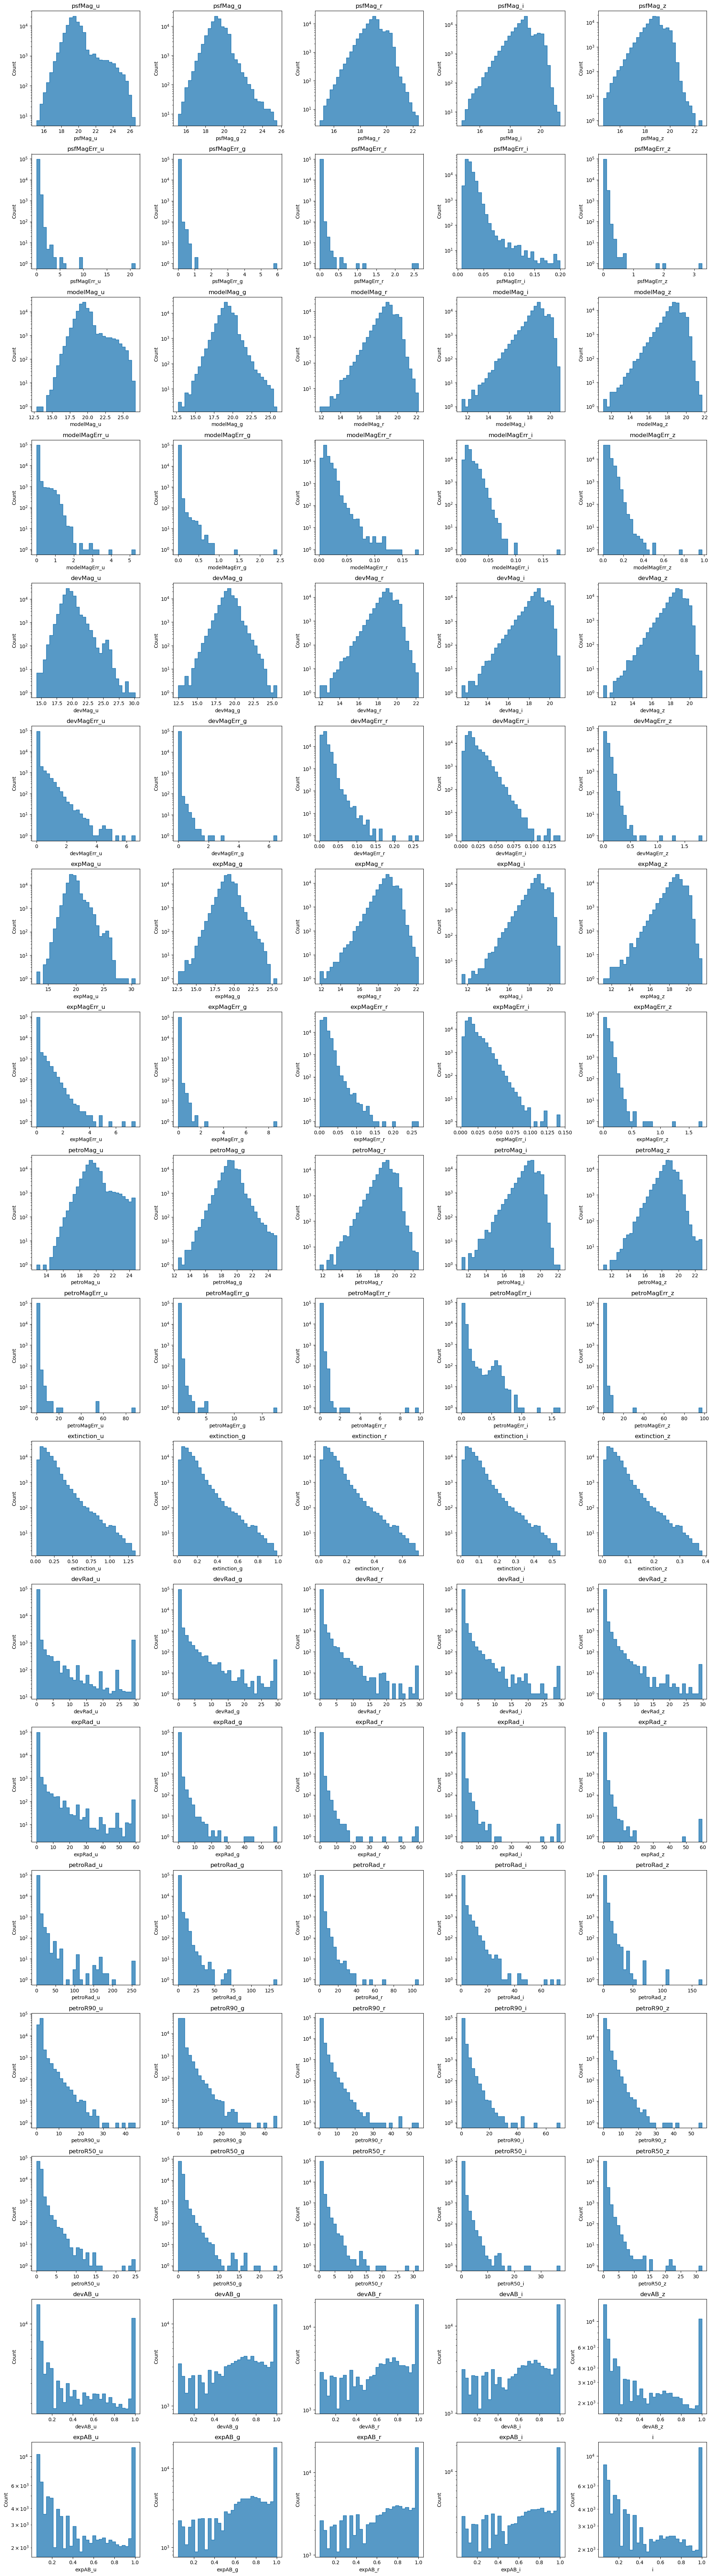

from  102116 intial objects we have now 99794
object discarded: 2322
['--- 77.588 seconds ---']


In [3]:
start_time = time.time()

# Download FITS file, if it does not exist
url = "http://dame.na.astro.it/fileShare/catania_cavuoti.fit"
file_name = "catania_cavuoti.fit"
if not os.path.exists(file_name):
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)

# Read FITS file
with fits.open(file_name) as hdul:
    data = hdul[1].data
    df = pd.DataFrame(data.tolist(), columns=data.names)
    
    
# Let's ingore some columns, identify the target columns, use the rest as features
ignore = ["specObjID", "objid", "ra", "dec", "targetObjID", "zErr"]
target = "z"
features = [col for col in df.columns if col not in ignore + [target]]


# Filter out negative values in features
objinthecatalog=df.shape[0]
df = df[(df[features] >= 0).all(axis=1)]
remainingobj=df.shape[0]

plot_feature_distributions(df, features, 5)


print("from ",objinthecatalog,"intial objects we have now", remainingobj)
print("object discarded:", objinthecatalog-remainingobj)

# Train-test split
#NB: I set 20% for the training to reduce the training time, clearly, such a choice does not make sense
seed = 42
train_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], train_size=train_size, random_state=seed)
print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])



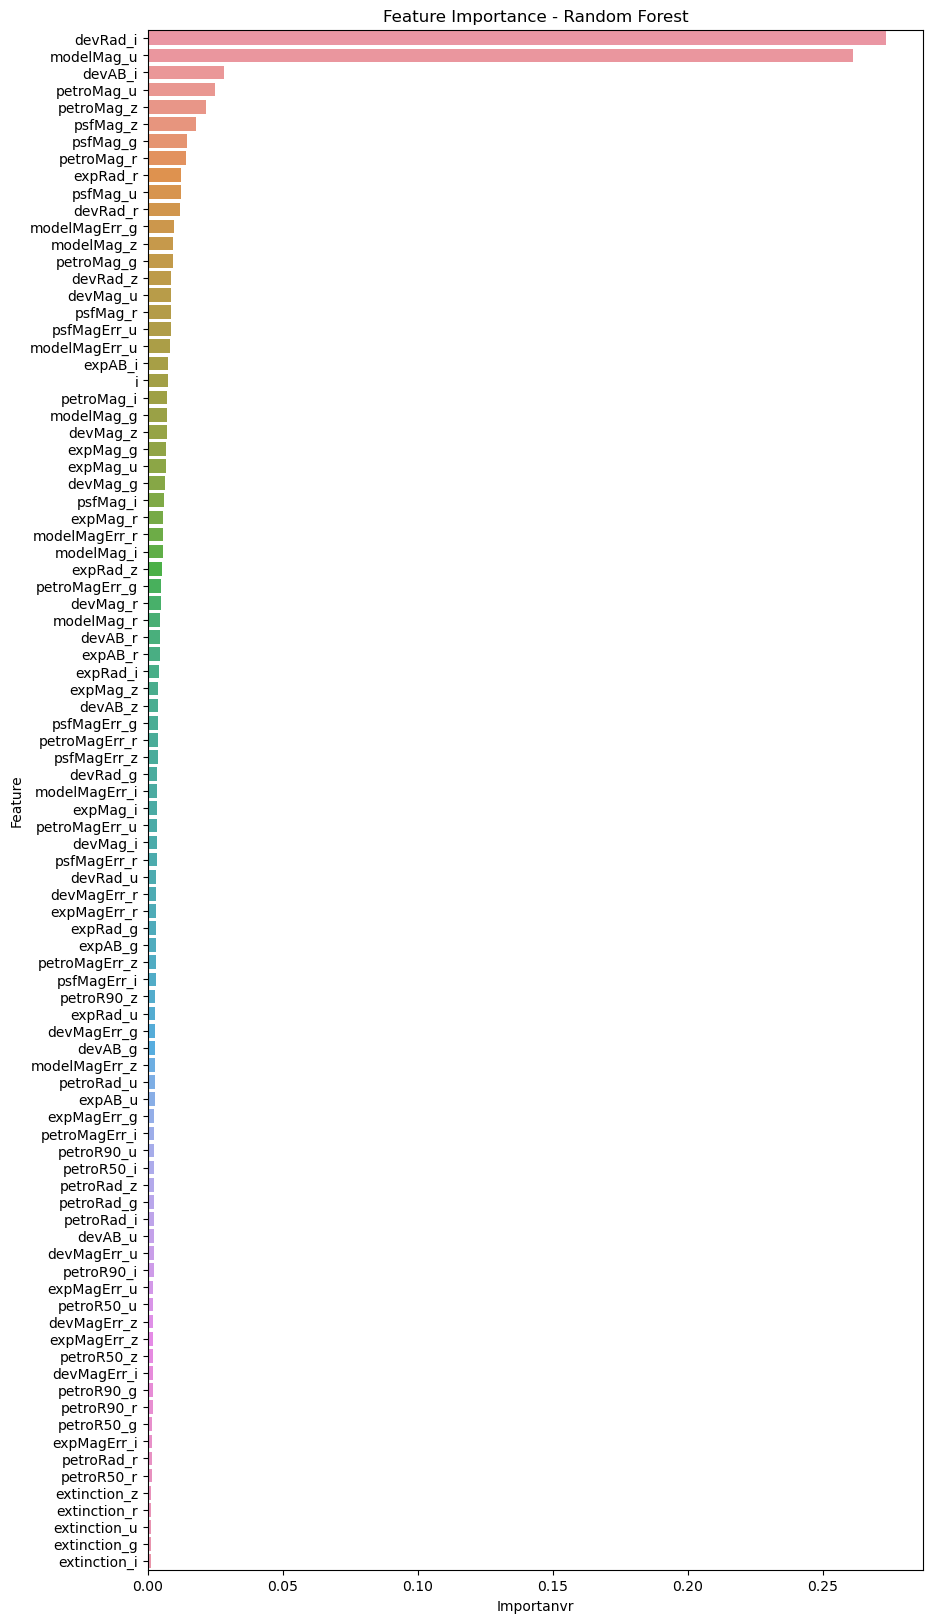

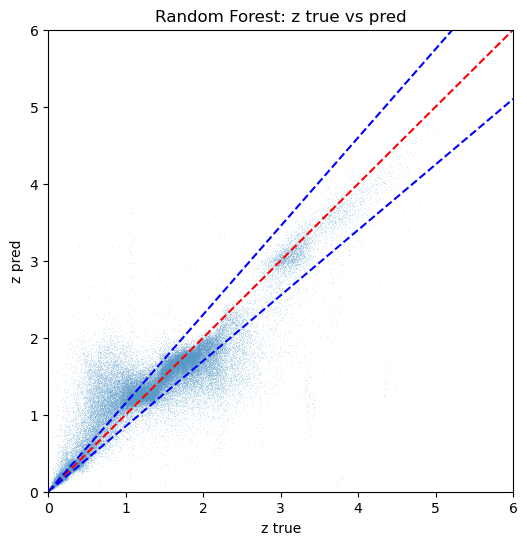

Random Forest: z true vs pred - Mean Residual: 0.02793167610246561, Std Residual: 0.17845342114215407, Outliers > 0.15: 22.39%
['--- 117.525 seconds ---']


In [4]:
start_time = time.time()

# Simple Experiment with a Random Forest (with just 100 trees, to reduce training time)
#rf = RandomForestRegressor(n_estimators=500,random_state=seed,n_jobs=-1)
rf = RandomForestRegressor(n_estimators=100,random_state=seed,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)
# Feature Importance plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
plt.xlabel("Importanvr")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.show()

# result plot
scatter_plot(y_test, y_pred_rf,"Random Forest: z true vs pred")



print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])

# Grid Search for RF
## takes to much time ...

Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}


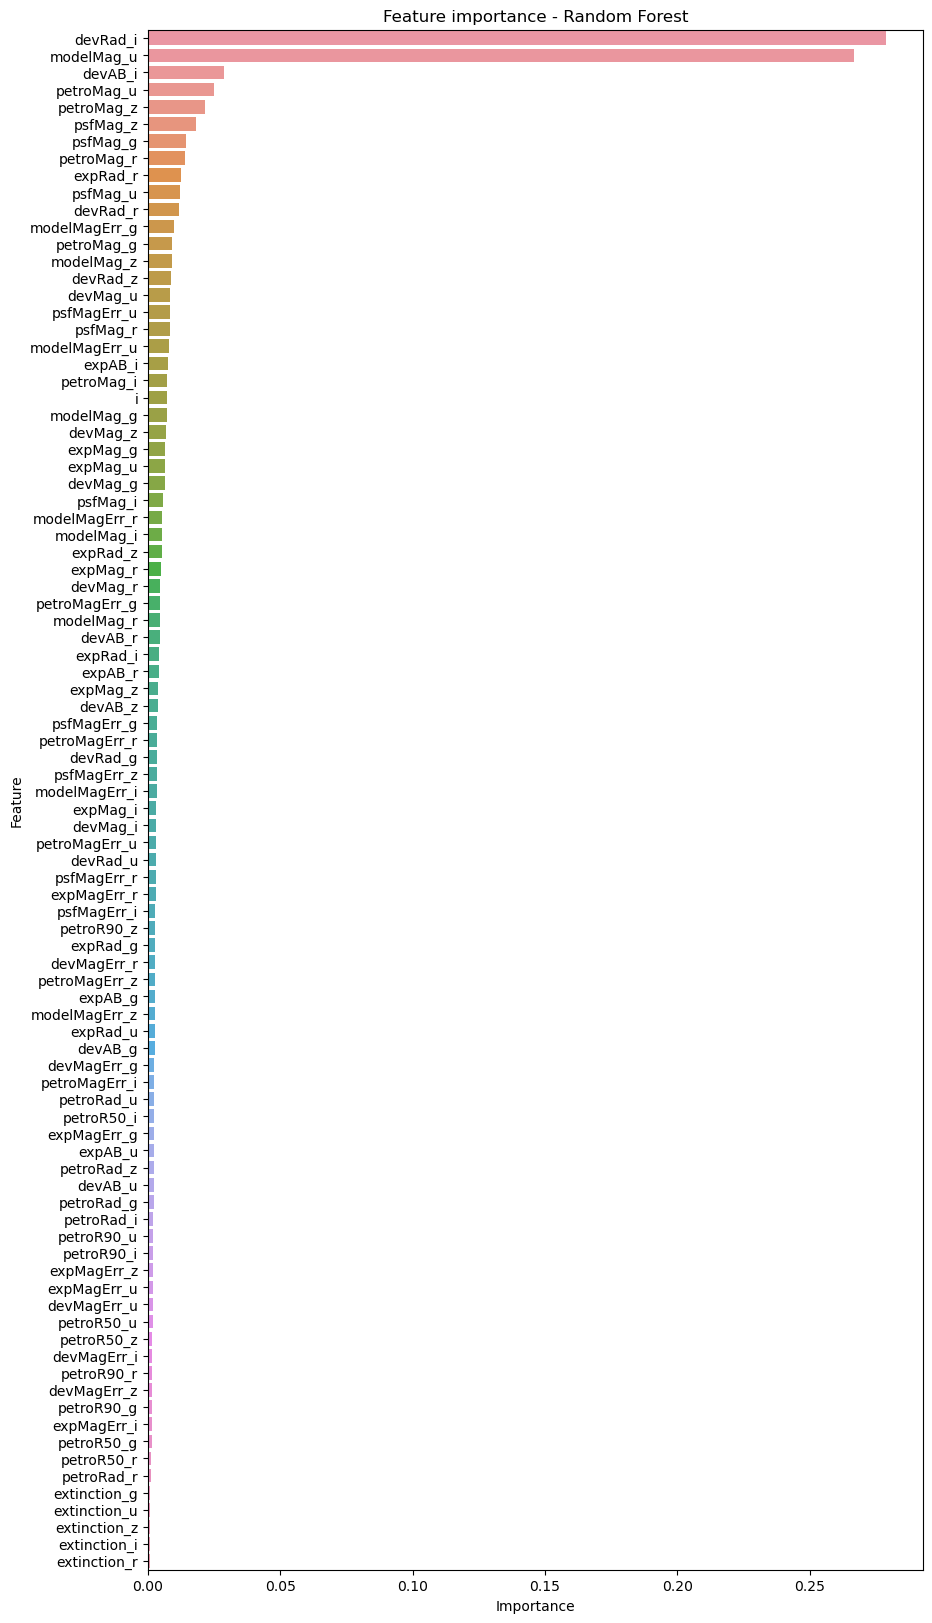

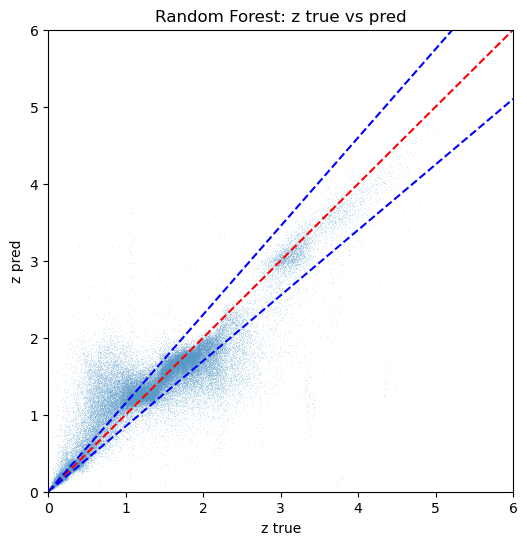

Random Forest: z true vs pred - Mean Residual: 0.02793167610246561, Std Residual: 0.17845342114215407, Outliers > 0.15: 22.39%


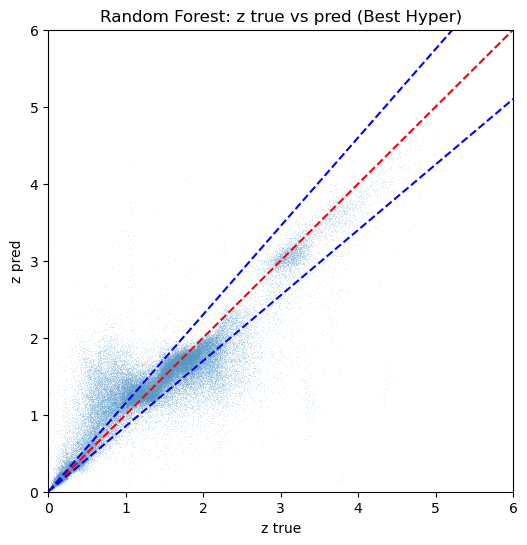

Random Forest: z true vs pred (Best Hyper) - Mean Residual: 0.027241119951850138, Std Residual: 0.1779523422359786, Outliers > 0.15: 22.18%
['--- 1868.005 seconds ---']


In [5]:
start_time = time.time()

# Grid Search for Random Forest (it's a dict)
#we are testing these combinations:
param_grid = {'max_depth': [10, 30, None], #maximum dept of the tree; None means that nodes are expanded until all leaves are pure or contains less than min_samples_split samples
        'min_samples_split': [2, 5], #minimum number of samples required to split a node
        'min_samples_leaf': [1, 2],} #minimum number of samples required to be a leaf node


#Coefficient of determination: r2 = 1 - RSS/TSS; where
# SSR = residual sum of squares, i.e. RSS = \sum_i (y_true_i-y_pred_i)^2
# SST = total sum of squares (~variance), i.e. RSS = \sum_i (y_true_i - mu)^2, mu is mean of y_true
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=seed,n_estimators=100,n_jobs=10), param_grid, cv=3, scoring='r2', n_jobs=10)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Best parameters for Random Forest:", grid_search_rf.best_params_) 
#OUTPUT: {max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}

# Feature importance
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)
# Plot della Feature Importance
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance - Random Forest")
plt.show()

scatter_plot(y_test, y_pred_rf,"Random Forest: z true vs pred")

scatter_plot(y_test, y_pred_best_rf,"Random Forest: z true vs pred (Best Hyper)")

print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])

# kNN Experiment

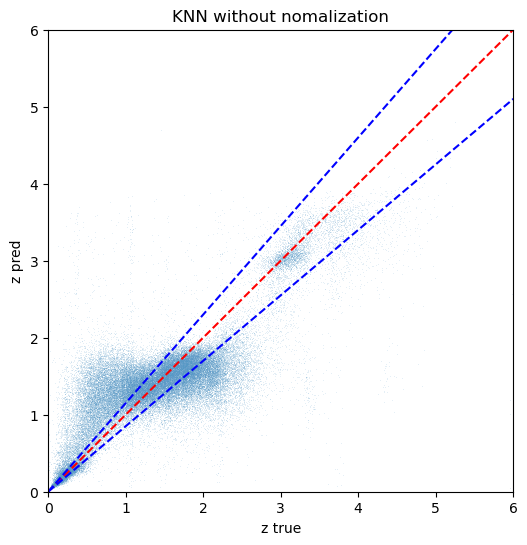

KNN without nomalization - Mean Residual: 0.038766499233010496, Std Residual: 0.22727654728556787, Outliers > 0.15: 35.55%


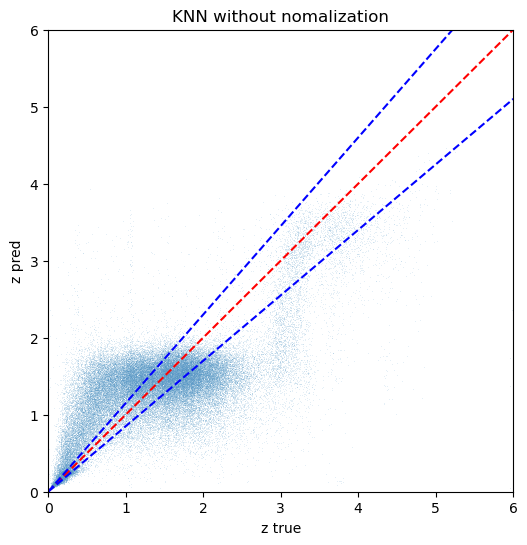

KNN without nomalization - Mean Residual: 0.03319190391133949, Std Residual: 0.2567068636876979, Outliers > 0.15: 49.66%


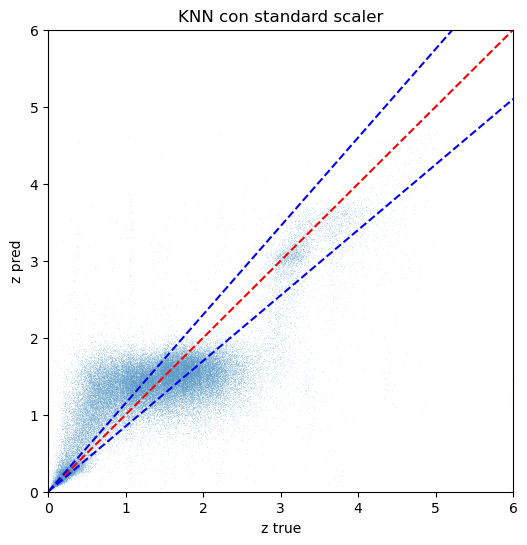

KNN con standard scaler - Mean Residual: 0.03750904572628415, Std Residual: 0.23316524456910306, Outliers > 0.15: 41.81%
['--- 10.785 seconds ---']


In [6]:
# kNN Experiment
start_time = time.time()

#Data set resclaing, suggested for clustering methods
# 1) MinMax scaling, values within 0-1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 2) Standard scaling, values with 0-mean, 1-std
scaler2=StandardScaler()
X_train_standard_scaled = scaler2.fit_transform(X_train)
X_test_standard_scaled = scaler2.transform(X_test)

#kNN for the unscaled data
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#kNN for the minmax-scaled data
knn_scaled = KNeighborsRegressor(n_neighbors=10)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)

#kNN for the standard-scaled data
knn_standard_scaled = KNeighborsRegressor(n_neighbors=10)
knn_standard_scaled.fit(X_train_standard_scaled, y_train)
y_pred_knn_standard_scaled = knn_standard_scaled.predict(X_test_standard_scaled)

scatter_plot(y_test, y_pred_knn,"KNN without nomalization")
scatter_plot(y_test, y_pred_knn_scaled,"KNN without nomalization")
scatter_plot(y_test, y_pred_knn_standard_scaled,"KNN con standard scaler")

print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])

# MLP Experiment

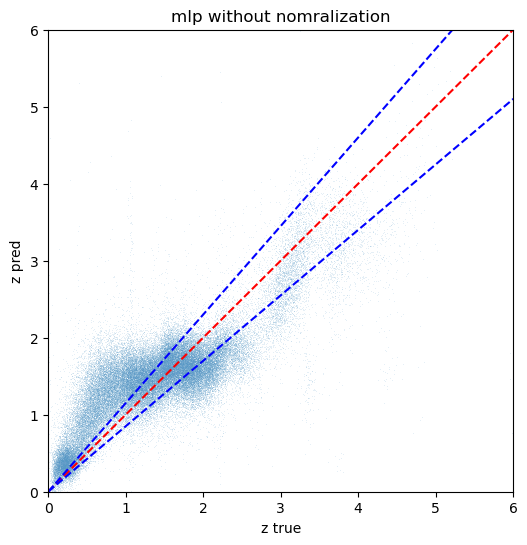

mlp without nomralization - Mean Residual: 0.07148683488555323, Std Residual: 0.22943128779914956, Outliers > 0.15: 41.99%


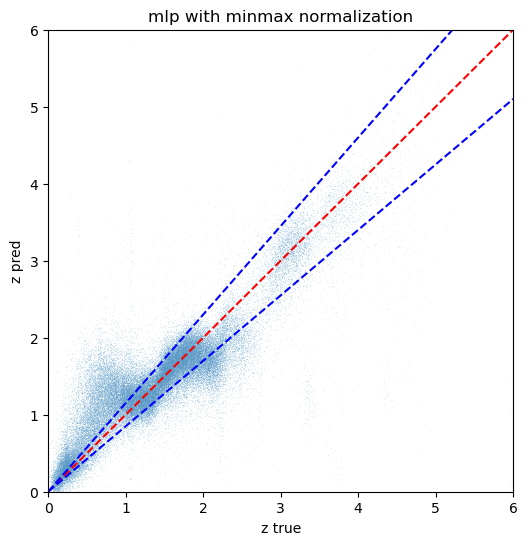

mlp with minmax normalization - Mean Residual: 0.04363255486653965, Std Residual: 0.19152442518262136, Outliers > 0.15: 25.73%


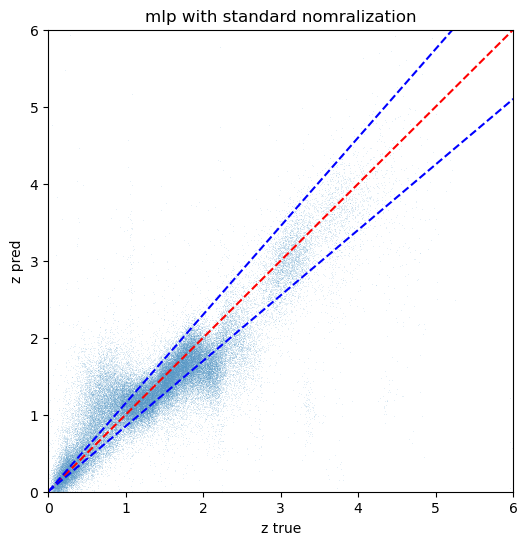

mlp with standard nomralization - Mean Residual: 0.0010444405443579194, Std Residual: 0.20059868916649054, Outliers > 0.15: 23.99%
['--- 120.209 seconds ---']


In [7]:
start_time = time.time()

# MLP Experiment

#Again, we are going to test the two scalers
scaler = MinMaxScaler()
scaler2=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_standard_scaled = scaler2.fit_transform(X_train)
X_test_standard_scaled = scaler2.transform(X_test)

mlp = MLPRegressor(random_state=seed, max_iter=500)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

mlp_scaled = MLPRegressor(random_state=seed, max_iter=500)
mlp_scaled.fit(X_train_scaled, y_train)
y_pred_mlp_scaled = mlp_scaled.predict(X_test_scaled)

mlp_standard_scaled = MLPRegressor(random_state=seed, max_iter=500)
mlp_standard_scaled.fit(X_train_standard_scaled, y_train)
y_pred_mlp_standard_scaled = mlp_standard_scaled.predict(X_test_standard_scaled)

scatter_plot(y_test, y_pred_mlp,"mlp without nomralization")
scatter_plot(y_test, y_pred_mlp_scaled,"mlp with minmax normalization")
scatter_plot(y_test, y_pred_mlp_standard_scaled,"mlp with standard nomralization")

print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])




# Let's use the top 10 features - MLP

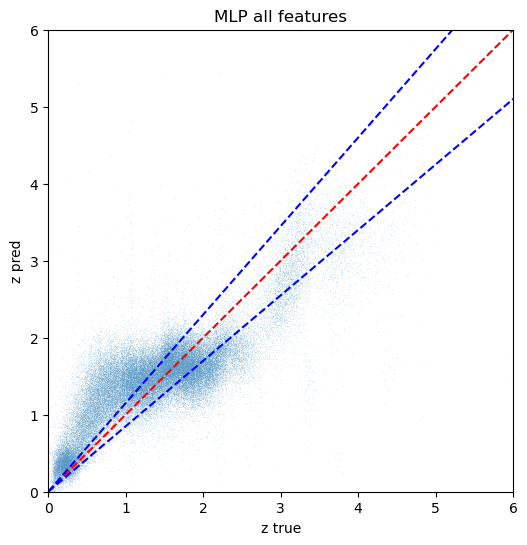

MLP all features - Mean Residual: 0.07148683488555323, Std Residual: 0.22943128779914956, Outliers > 0.15: 41.99%


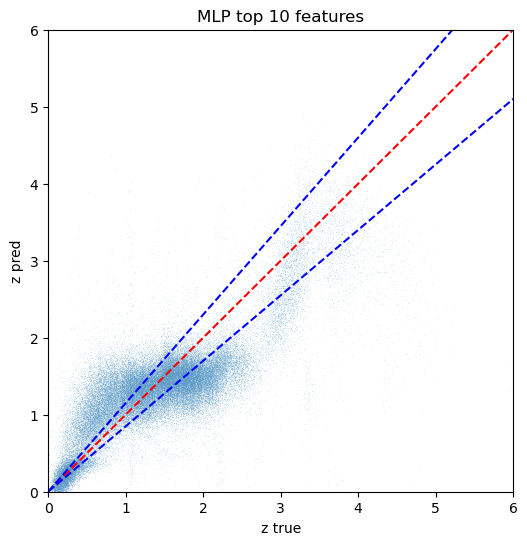

MLP top 10 features - Mean Residual: 0.0032405562461017483, Std Residual: 0.20501483552391706, Outliers > 0.15: 40.63%


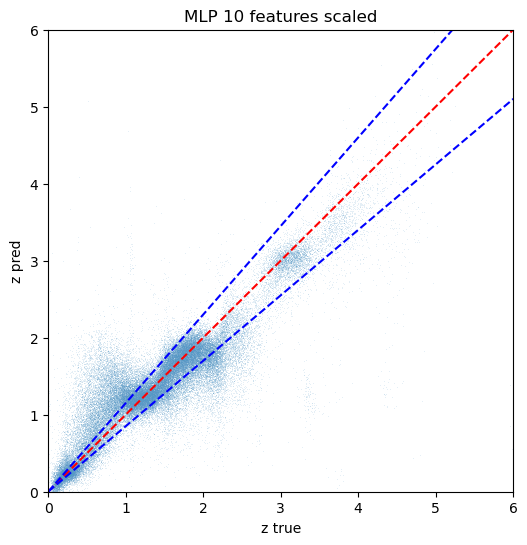

MLP 10 features scaled - Mean Residual: 0.021527047073334877, Std Residual: 0.17785842064483884, Outliers > 0.15: 21.86%
['--- 23.645 seconds ---']


In [8]:
# Experiment with the best 10 features - MLP
start_time = time.time()

top_10_features = feature_importance_df.head(10)["Feature"].tolist()
X_train_top10, X_test_top10 = X_train[top_10_features], X_test[top_10_features]
X_train_scaled_top10 = scaler2.fit_transform(X_train_top10)
X_test_scaled_top10 = scaler2.transform(X_test_top10)

mlp_top10 = MLPRegressor(random_state=seed, max_iter=1000)
mlp_top10.fit(X_train_top10, y_train)
y_pred_mlp_top10 = mlp_top10.predict(X_test_top10)

scatter_plot(y_test, y_pred_mlp,"MLP all features")
scatter_plot(y_test, y_pred_mlp_top10,"MLP top 10 features")

mlp_top10.fit(X_train_scaled_top10, y_train)
y_pred_mlp_scaled_top10 = mlp_top10.predict(X_test_scaled_top10)

scatter_plot(y_test, y_pred_mlp_scaled_top10,"MLP 10 features scaled")
print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])

# Let's use the top 10 features - kNN

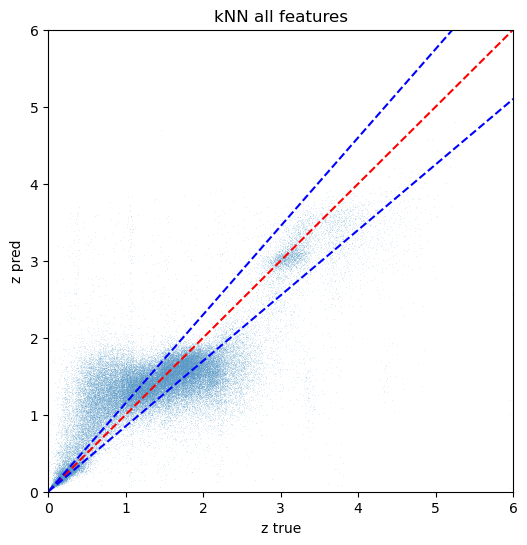

kNN all features - Mean Residual: 0.038766499233010496, Std Residual: 0.22727654728556787, Outliers > 0.15: 35.55%


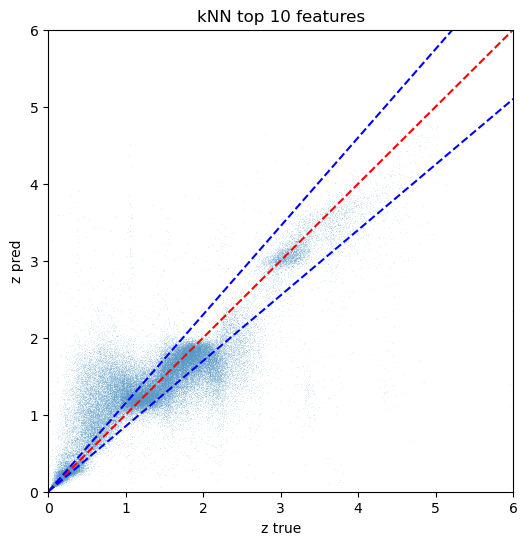

kNN top 10 features - Mean Residual: 0.03758616154698704, Std Residual: 0.2037112790761555, Outliers > 0.15: 26.78%
['--- 13.07 seconds ---']


In [9]:
start_time = time.time()

# Esperimento con le 10 migliori feature
top_10_features = feature_importance_df.head(10)["Feature"].tolist()
X_train_top10, X_test_top10 = X_train[top_10_features], X_test[top_10_features]
X_train_scaled_top10 = scaler2.fit_transform(X_train_top10)
X_test_scaled_top10 = scaler2.transform(X_test_top10)

knn.fit(X_train_top10, y_train)
y_pred_knn_top10 = knn.predict(X_test_top10)

scatter_plot(y_test, y_pred_knn,"kNN all features")
scatter_plot(y_test, y_pred_knn_top10,"kNN top 10 features")

knn.fit(X_train_scaled_top10, y_train)
y_pred_knn_scaled_top10 = knn.predict(X_test_scaled_top10)

# scatter_plot(y_test, y_pred_knn_scaled_top10,"KNN 10 features scaled")
print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])

# Let's use the top 10 features - kNN vs MLP vs RF

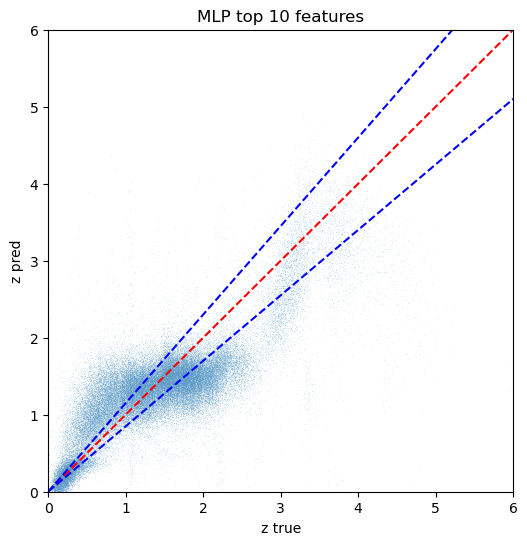

MLP top 10 features - Mean Residual: 0.0032405562461017483, Std Residual: 0.20501483552391706, Outliers > 0.15: 40.63%


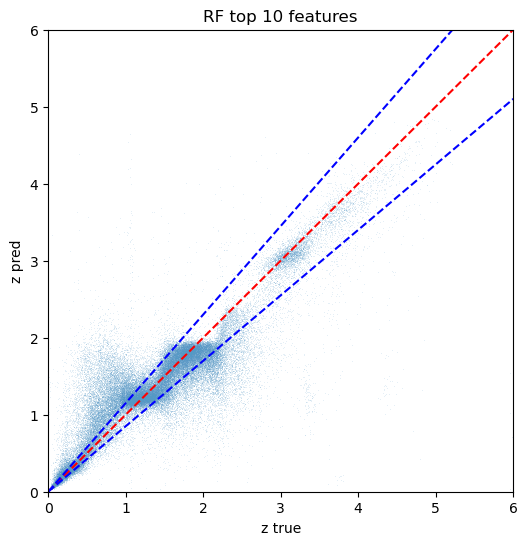

RF top 10 features - Mean Residual: 0.026142626891215867, Std Residual: 0.18051384432546813, Outliers > 0.15: 21.87%


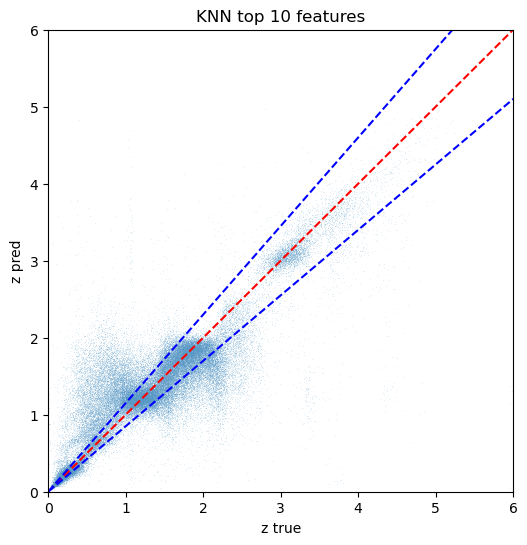

KNN top 10 features - Mean Residual: 0.0351362629980354, Std Residual: 0.20712651550413097, Outliers > 0.15: 26.02%
['--- 89.077 seconds ---']


In [10]:
start_time = time.time()

# KNN, MLP, RF sulle 10 migliori feature
mlp = MLPRegressor(random_state=seed, max_iter=500)
#As suggested by the GridSearch: {max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}
rf_top10 = RandomForestRegressor(random_state=seed, max_depth= 30, min_samples_leaf= 2, min_samples_split= 5,n_estimators=500,n_jobs=10)
knn_top10 = KNeighborsRegressor()

mlp.fit(X_train_top10, y_train)
rf_top10.fit(X_train_top10, y_train)
knn_top10.fit(X_train_top10, y_train)

y_pred_mlp = mlp.predict(X_test_top10)
y_pred_rf_top10 = rf_top10.predict(X_test_top10)
y_pred_knn_top10 = knn_top10.predict(X_test_top10)

scatter_plot(y_test, y_pred_mlp,"MLP top 10 features" )
scatter_plot(y_test, y_pred_rf_top10,"RF top 10 features")
scatter_plot(y_test, y_pred_knn_top10,"KNN top 10 features")
print(["--- "+ str(round((time.time() - start_time),3)) +" seconds ---"])